In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ========== Stratified Split (80% Train, 20% Test) ==========
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Binary_class"], random_state=42)

# ========== Save Split Data (Kaggle uses `/kaggle/working` for output) ==========
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# ========== Summary Table ==========
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Binary_class"].value_counts(),
    "Test (20%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# ========== Save Summary Table ==========
split_summary.to_csv("/kaggle/working/split_summary.csv")

# ========== Display ==========
print("\nData Split Summary:\n", split_summary)
print("\n✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.")



Data Split Summary:
 Binary_class  Non-Damage  Damage
Train (80%)        12403    2062
Test (20%)          3102     515
Total              15505    2577

✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.


Before SMOTE - Train: [12403  2062]
After SMOTE - Train: [12403 12403]
Before SMOTE - Test: [3102  515]
After SMOTE - Test: [3102 3102]
Epoch 1/10
388/388 - 4s - 10ms/step - accuracy: 0.8634 - loss: 0.3239
Epoch 2/10
388/388 - 1s - 2ms/step - accuracy: 0.9656 - loss: 0.1026
Epoch 3/10
388/388 - 1s - 2ms/step - accuracy: 0.9878 - loss: 0.0406
Epoch 4/10
388/388 - 1s - 2ms/step - accuracy: 0.9921 - loss: 0.0237
Epoch 5/10
388/388 - 1s - 2ms/step - accuracy: 0.9937 - loss: 0.0183
Epoch 6/10
388/388 - 1s - 2ms/step - accuracy: 0.9950 - loss: 0.0143
Epoch 7/10
388/388 - 1s - 2ms/step - accuracy: 0.9953 - loss: 0.0132
Epoch 8/10
388/388 - 1s - 2ms/step - accuracy: 0.9954 - loss: 0.0121
Epoch 9/10
388/388 - 1s - 2ms/step - accuracy: 0.9954 - loss: 0.0124
Epoch 10/10
388/388 - 1s - 2ms/step - accuracy: 0.9954 - loss: 0.0118
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.7984
✅ Test ROC-AUC    : 0.9178
✅ Classi

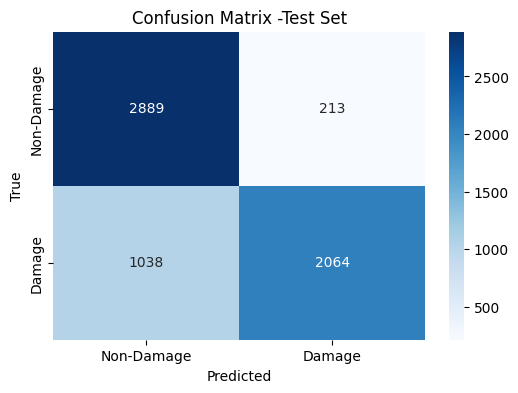

In [9]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ========== Load Dataset ==========
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
train_df['Binary_class'] = train_df['Binary_class'].str.strip().str.lower().map(label_map)
test_df['Binary_class'] = test_df['Binary_class'].str.strip().str.lower().map(label_map)

# ========== Handle Missing Text ==========
train_df['Processed_data'] = train_df['Processed_data'].fillna("")
test_df['Processed_data'] = test_df['Processed_data'].fillna("")

# ========== TF-IDF Vectorization ==========
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['Processed_data']).toarray()
X_test = vectorizer.transform(test_df['Processed_data']).toarray()

y_train = train_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# ========== Balance with SMOTE (Train & Test) ==========
print("Before SMOTE - Train:", np.bincount(y_train))
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE - Train:", np.bincount(y_train_smote))

print("Before SMOTE - Test:", np.bincount(y_test))
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)
print("After SMOTE - Test:", np.bincount(y_test_smote))

# ========== Build CNN Model ==========
model = Sequential([
    Input(shape=(X_train_smote.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ========== Train the Model ==========
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# ========== Evaluate on SMOTE-applied Test Set ==========
test_loss, test_accuracy = model.evaluate(X_test_smote, y_test_smote, verbose=0)
test_preds = (model.predict(X_test_smote) > 0.5).astype(int)
test_proba = model.predict(X_test_smote)
test_roc_auc = roc_auc_score(y_test_smote, test_proba)
test_report = classification_report(y_test_smote, test_preds, target_names=['Non-Damage', 'Damage'])

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {test_accuracy:.4f}")
print(f"✅ Test ROC-AUC    : {test_roc_auc:.4f}")
print("✅ Classification Report:\n", test_report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test_smote, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix -Test Set")
plt.show()
